## Run on Colab
You can run this notebook on Colab right away without installing JAX dependencies: https://colab.research.google.com/github/willwhitney/reprieve/blob/master/examples/example.ipynb.

## Run locally
To run this notebook locally please install the [Reprieve dependencies](https://github.com/willwhitney/reprieve#dependencies), in particular JAX with GPU support.

In [ ]:
!pip install jax==0.1.75 jaxlib==0.1.52 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
!pip install flax==0.1.0 git+https://github.com/willwhitney/reprieve

In [2]:
import os
import pandas as pd

import jax
import torchvision

import reprieve
from reprieve.representations import mnist_vae
from reprieve.mnist_noisy_label import MNISTNoisyLabelDataset
from reprieve.algorithms import mlp as alg

In [3]:
# make an MNIST dataset
dataset_mnist = torchvision.datasets.MNIST(
    './data', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))]))


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [ ]:
# make an MLP algorithm which takes inputs of shape (1, 28, 28)
# and has 10 output classes
init_fn, train_step_fn, eval_fn = alg.make_algorithm((1, 28, 28), 10)

# these functions initialize the state of the model given a seed, 
# train on a batch of data, 
# and evaluate on a batch of data

# construct a loss-data estimator and use it to compute the loss-data curve
raw_loss_data_estimator = reprieve.LossDataEstimator(
    init_fn, train_step_fn, eval_fn, dataset_mnist)
raw_results = raw_loss_data_estimator.compute_curve()

In [ ]:
# train a VAE with latent dimension 8
vae_repr = mnist_vae.build_repr(8)

# make an MLP algorithm which takes inputs of shape (8,) to match the VAE
# and has 10 output classes
init_fn, train_step_fn, eval_fn = alg.make_algorithm((8,), 10)

# construct a loss-data estimator and use it to compute the loss-data curve
# pass the VAE as our representation_fn
vae_loss_data_estimator = reprieve.LossDataEstimator(
    init_fn, train_step_fn, eval_fn, dataset_mnist, 
    representation_fn=vae_repr)
vae_results = vae_loss_data_estimator.compute_curve()

In [7]:
# name our experiments and concatenate them
raw_results['name'] = 'Raw'
vae_results['name'] = 'VAE'

outcome_df = pd.concat([
    raw_results,
    vae_results,
])

# pick some settings of n (training set size) and epsilon (loss tolerance)
ns = [60, 20000]
epsilons = [1, 0.2]

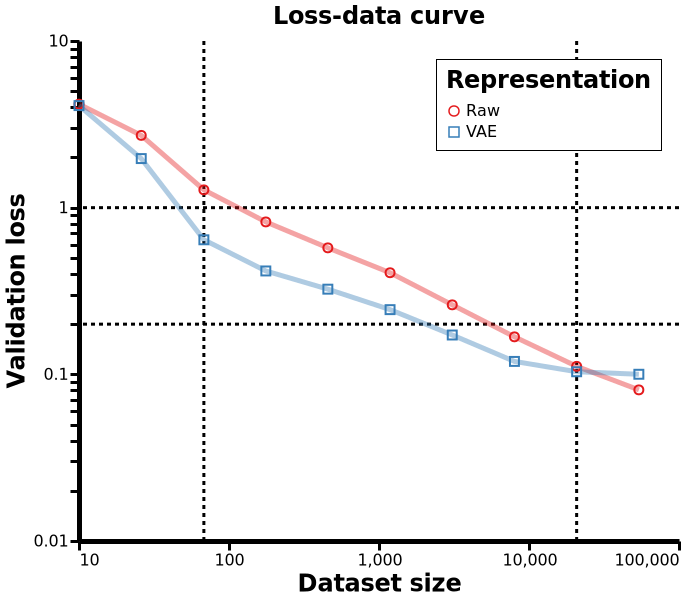

In [15]:
# plot the loss-data curves for our representations
reprieve.render_curve(outcome_df, ns, epsilons)

In [9]:
# compute VA, MDL, SDL, and eSC for both representations
metrics_df = reprieve.compute_metrics(outcome_df, ns, epsilons)
metrics_df

Name,Raw,VAE,Raw,VAE
n,68.0,68.0,20782.0,20782.0
Val loss,1.27876,0.641601,0.111662,0.10363
MDL,138.93,99.44,3432.78,2652.36
"SDL, eps=1",> 70.93,46.49,70.93,46.49
"SDL, eps=0.2",> 125.33,> 85.84,563.8,176.49
"eSC, eps=1",> 68.0,68,176,68
"eSC, eps=0.2",> 68.0,> 68.0,7998,3078


In [12]:
# reprieve even generates LaTeX tables you can paste into a paper
latex_text = reprieve.render_latex(metrics_df, display=True)

Output(layout=Layout(border='1px solid black'), outputs=({'output_type': 'stream', 'name': 'stdout', 'text': '…